In [9]:
import pytorch_nmf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mixes.synthetic import SyntheticDB
from tqdm import tqdm

# Penalties vizualization

100%|██████████| 1000/1000 [00:01<00:00, 899.23it/s]


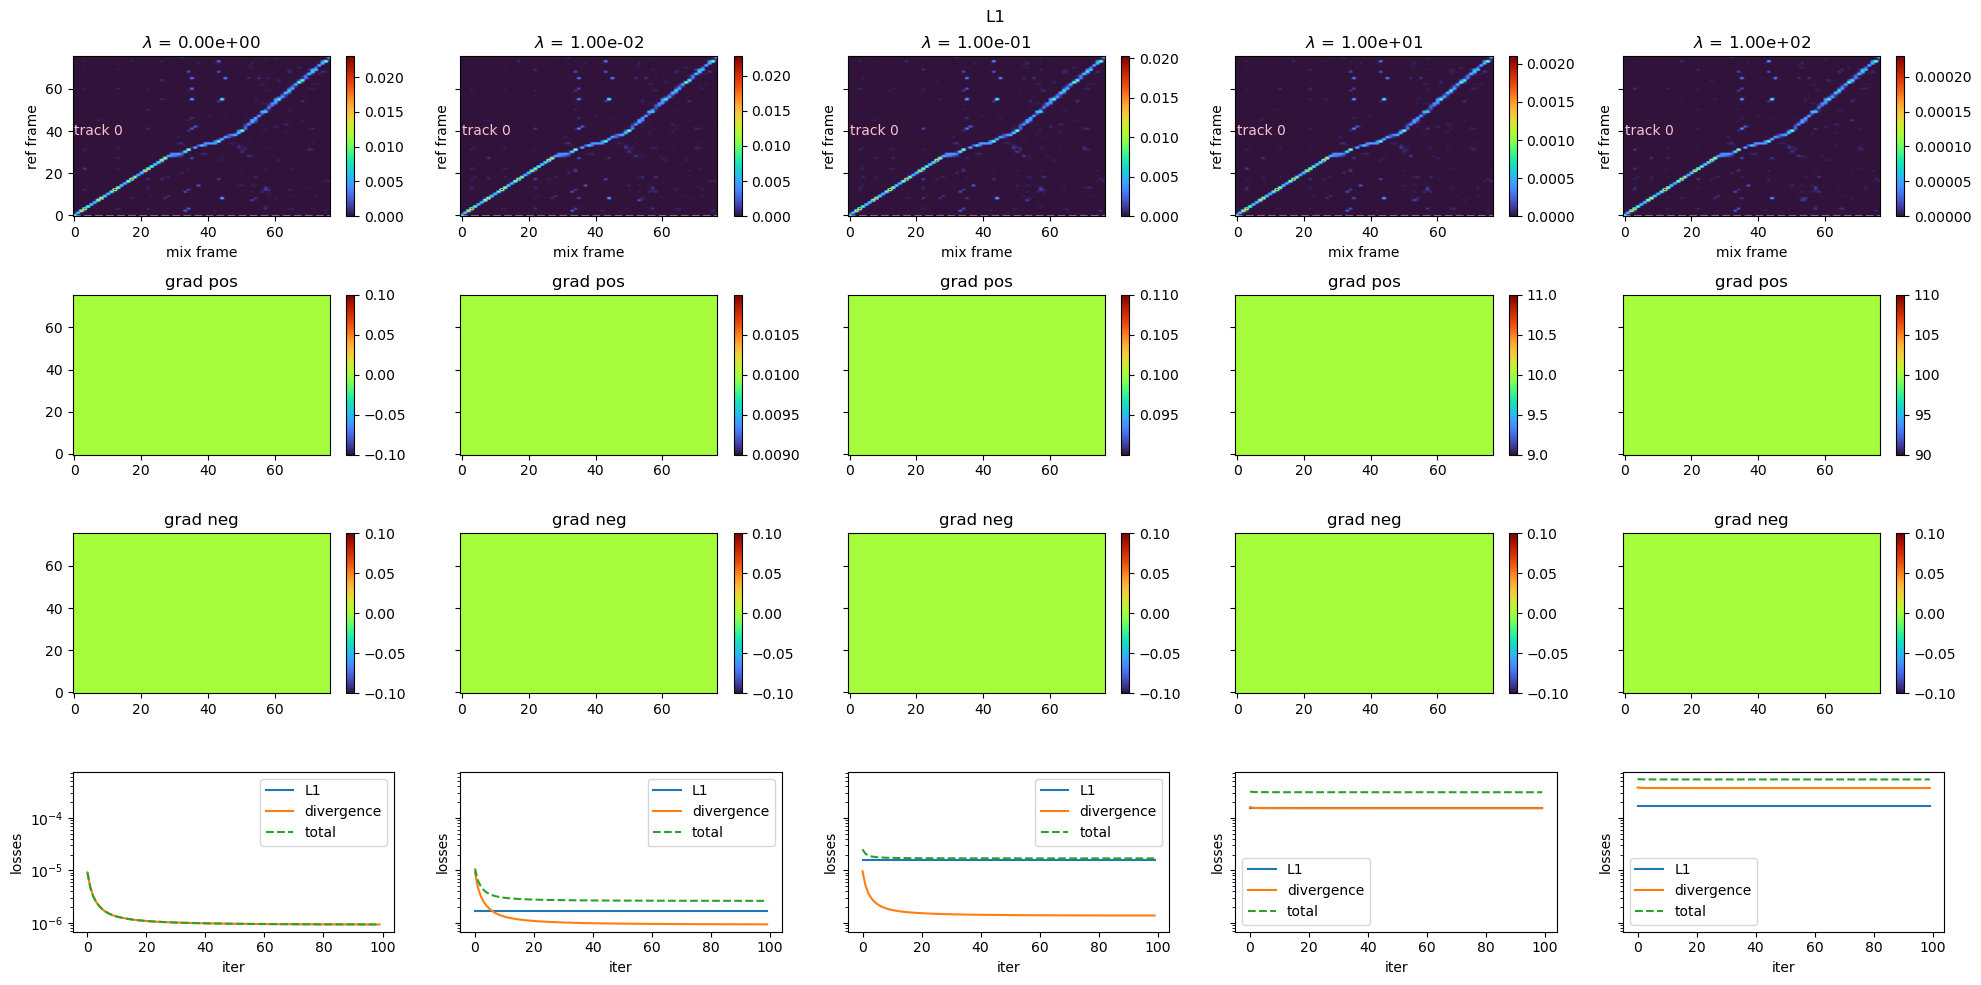

100%|██████████| 1000/1000 [00:00<00:00, 1039.69it/s]


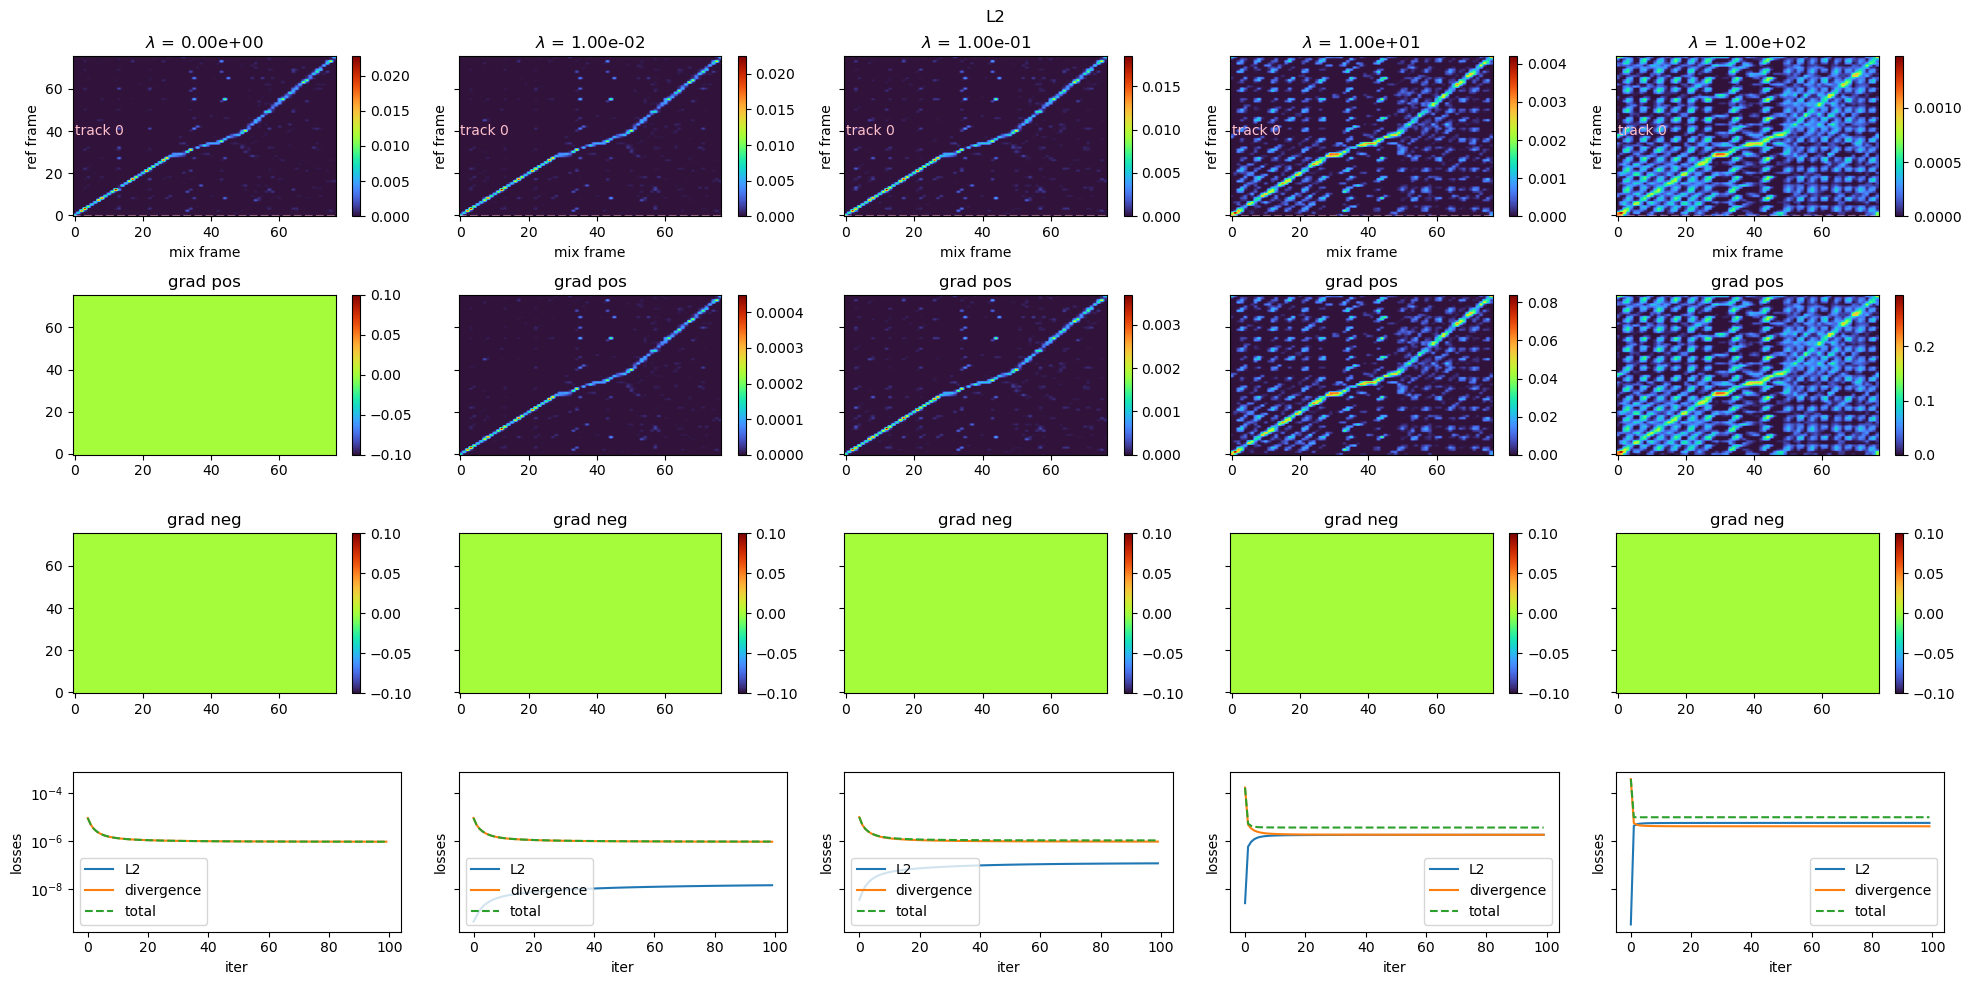

100%|██████████| 1000/1000 [00:01<00:00, 826.59it/s]


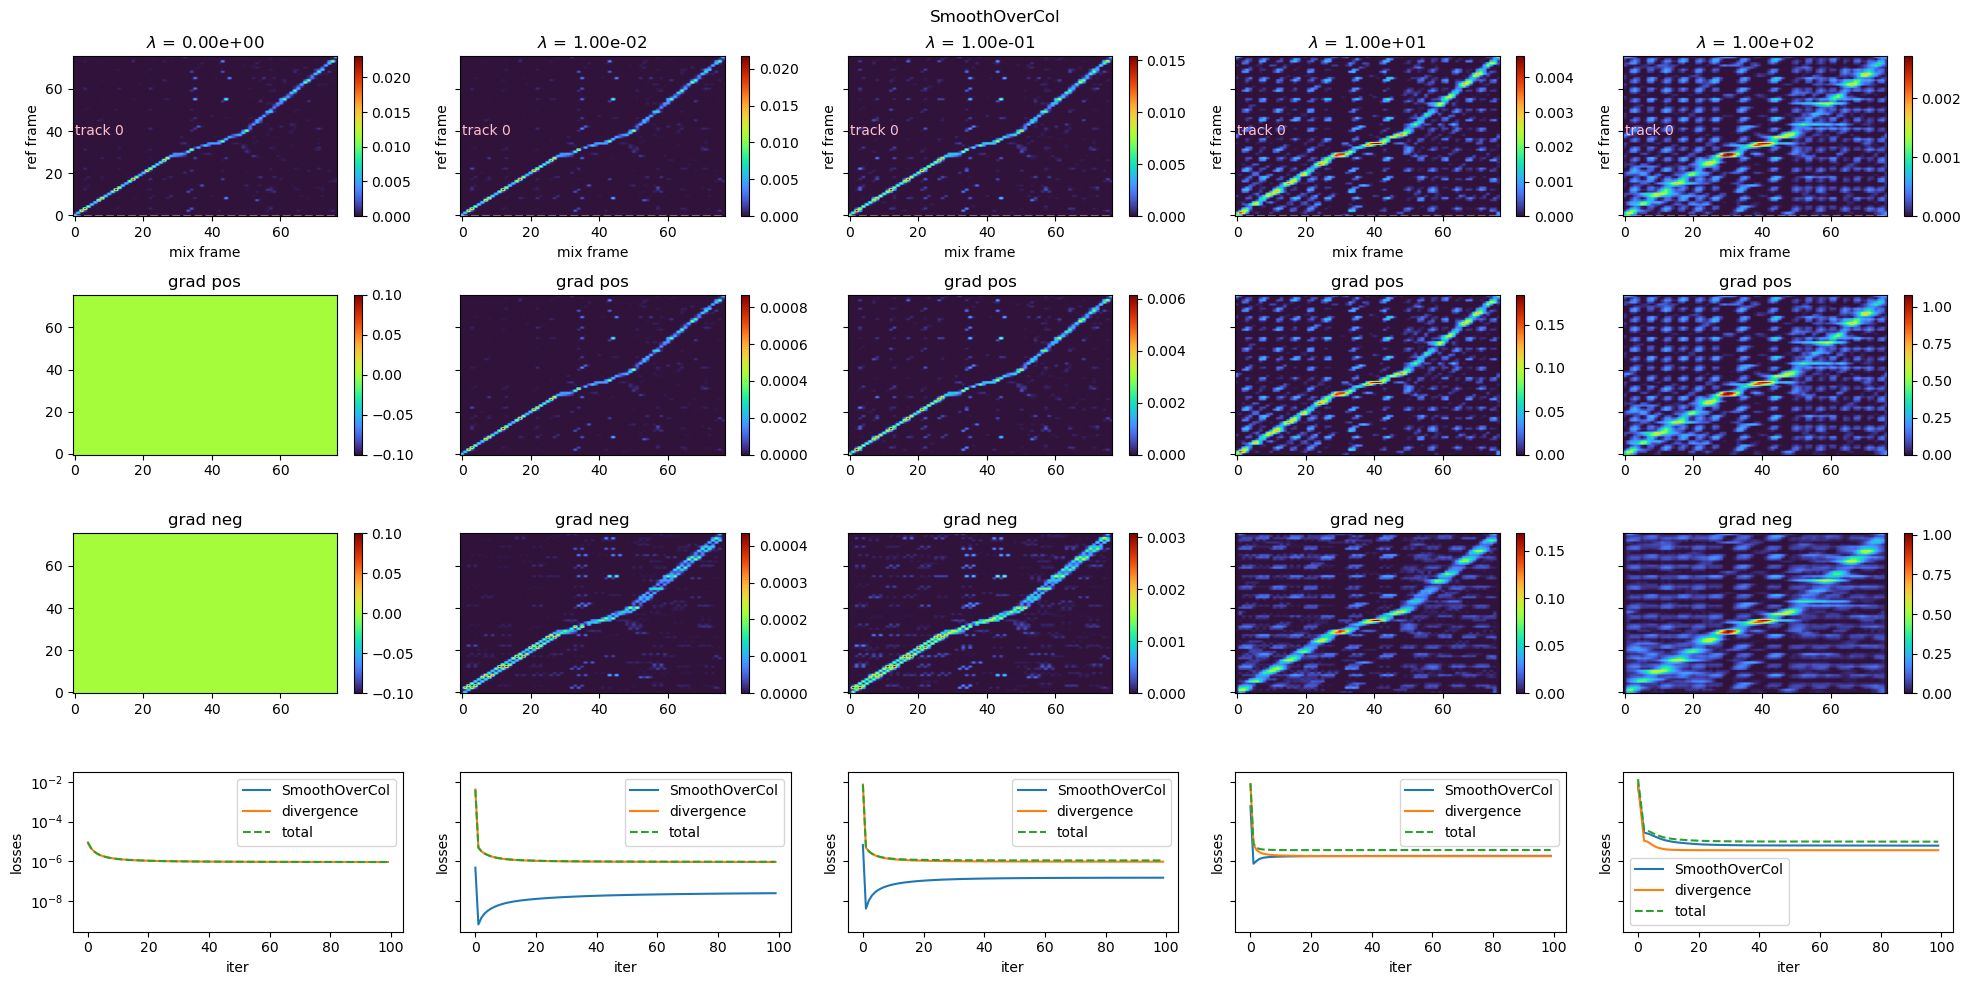

100%|██████████| 1000/1000 [00:01<00:00, 762.61it/s]


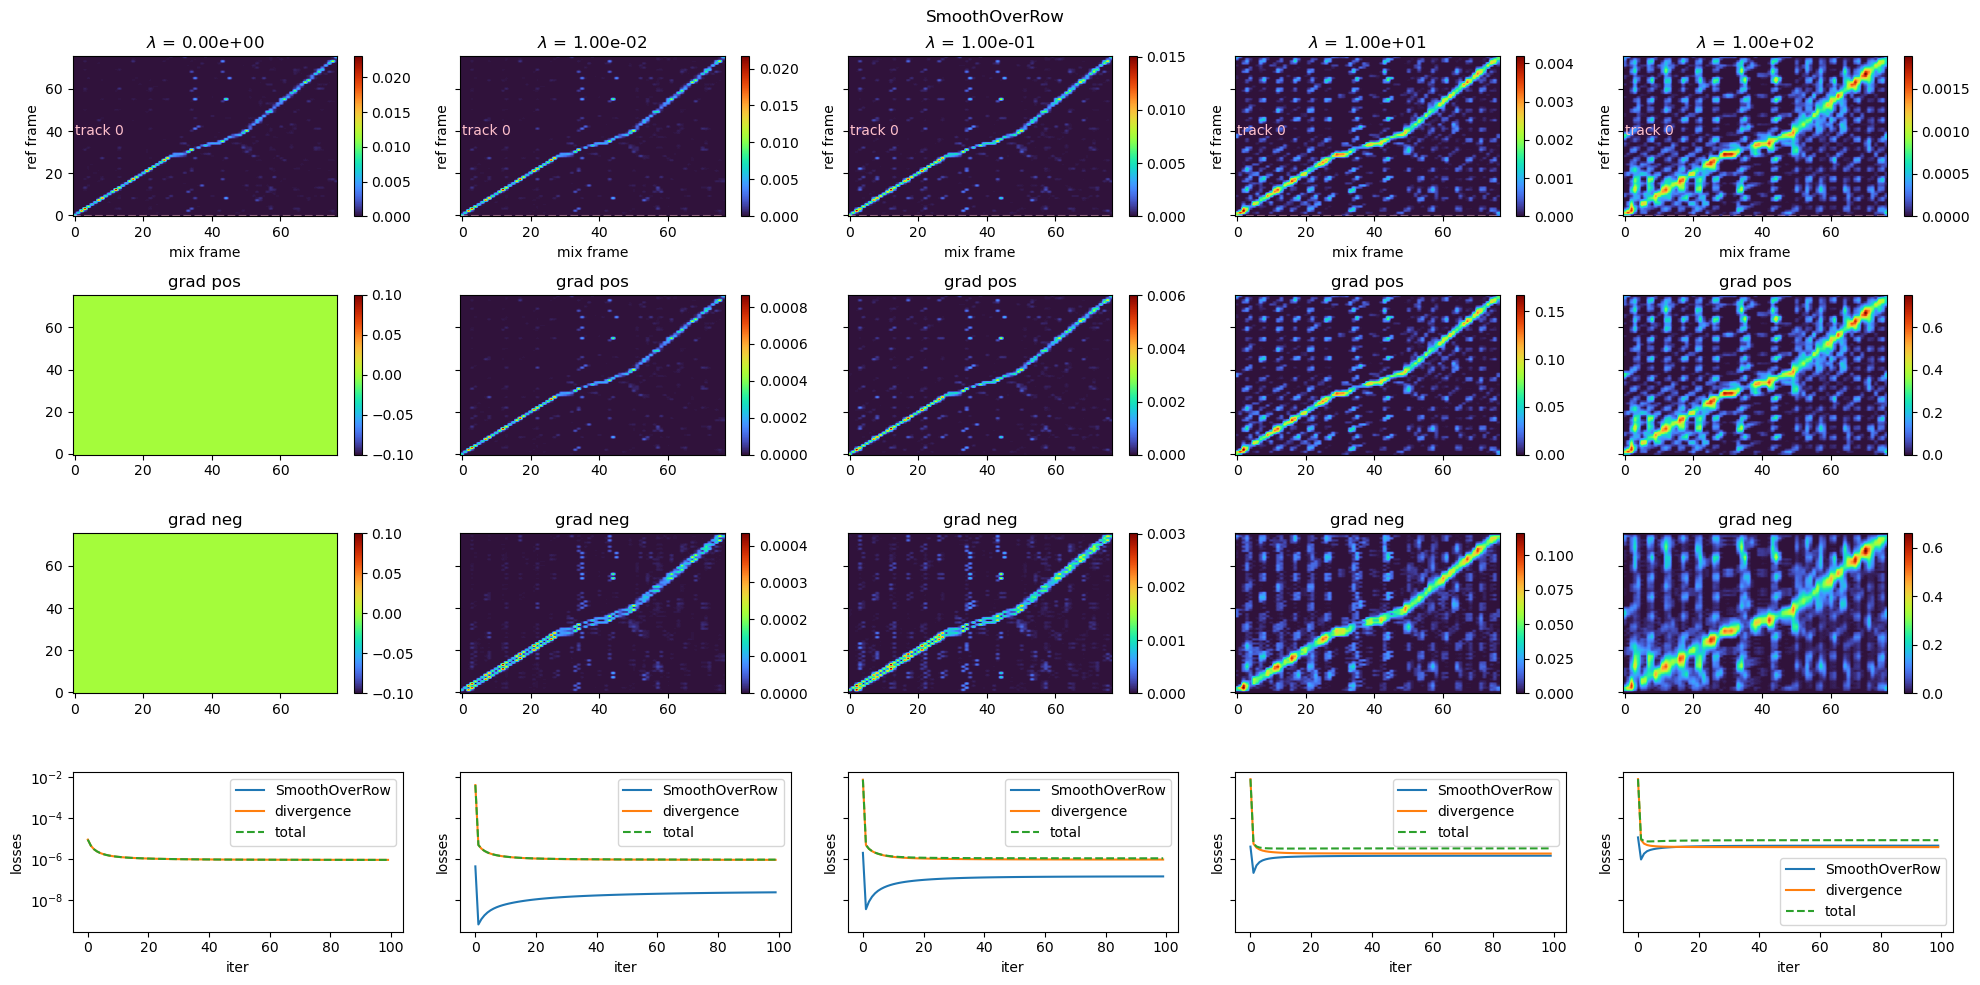

100%|██████████| 1000/1000 [00:01<00:00, 673.30it/s]


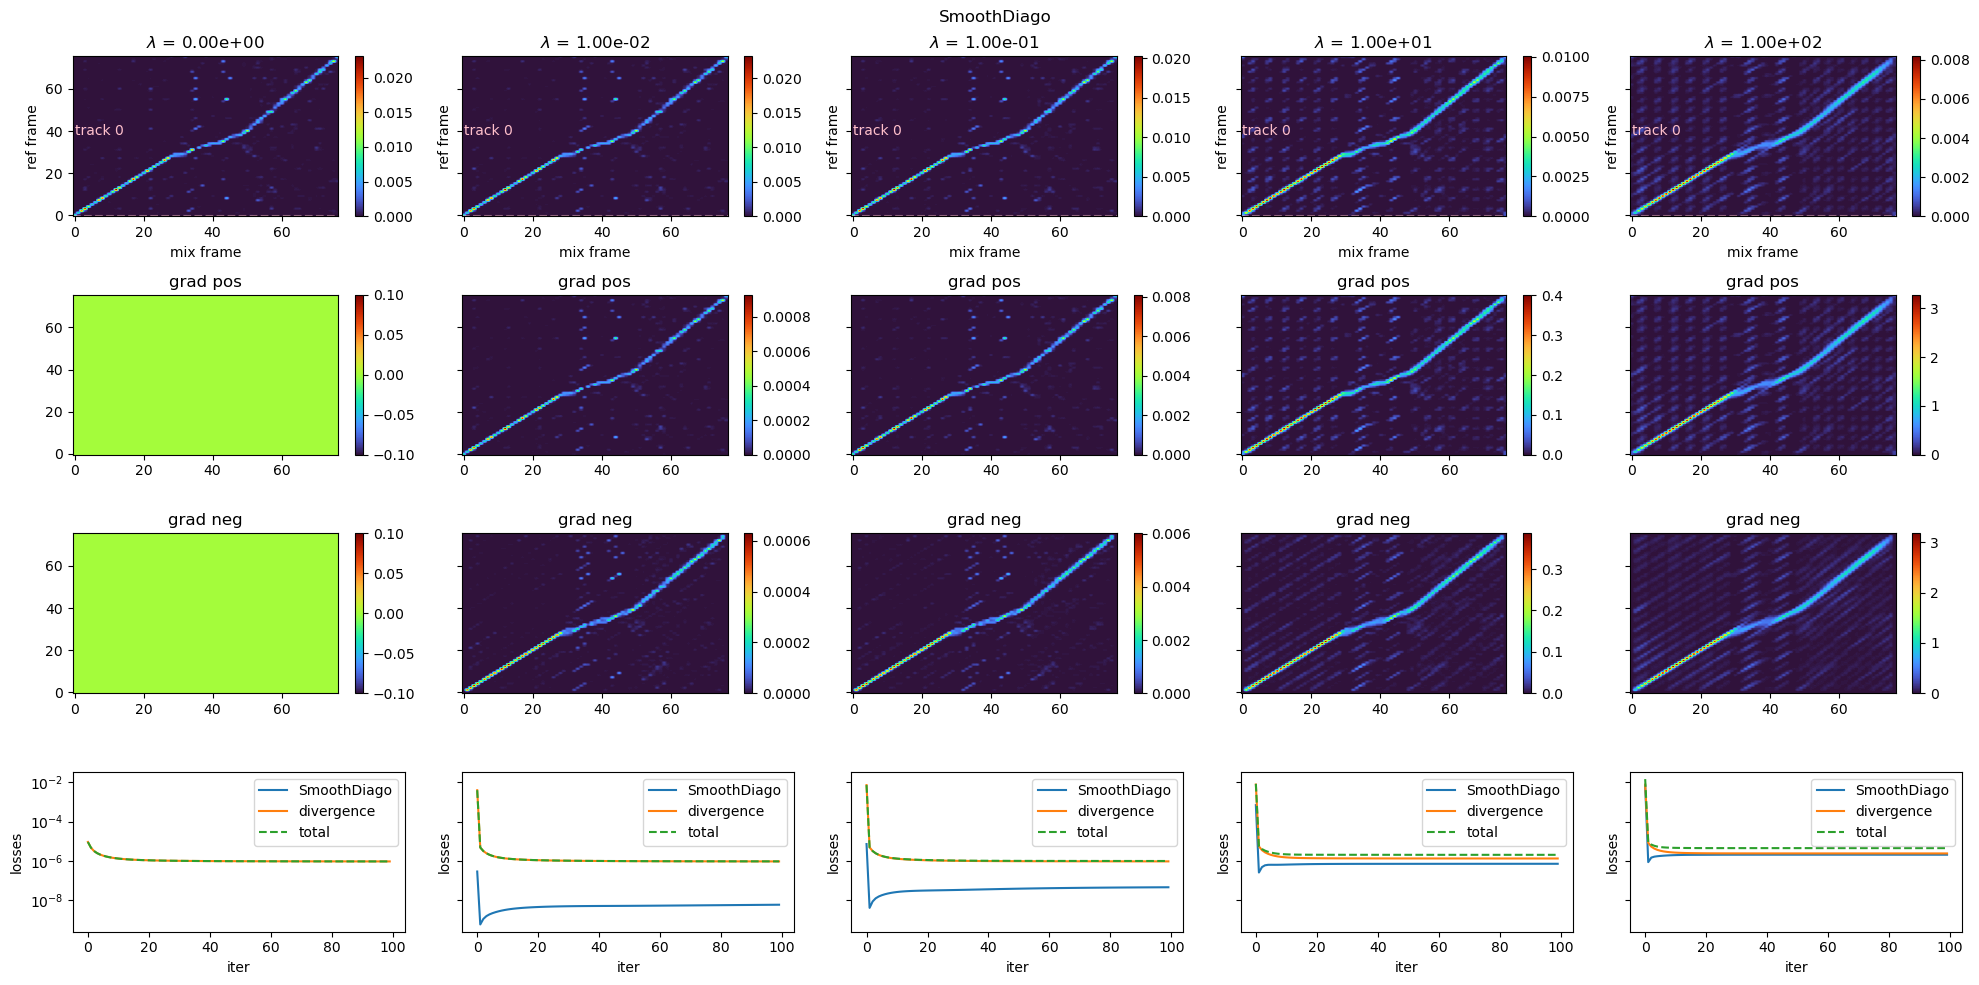

100%|██████████| 1000/1000 [00:01<00:00, 660.91it/s]


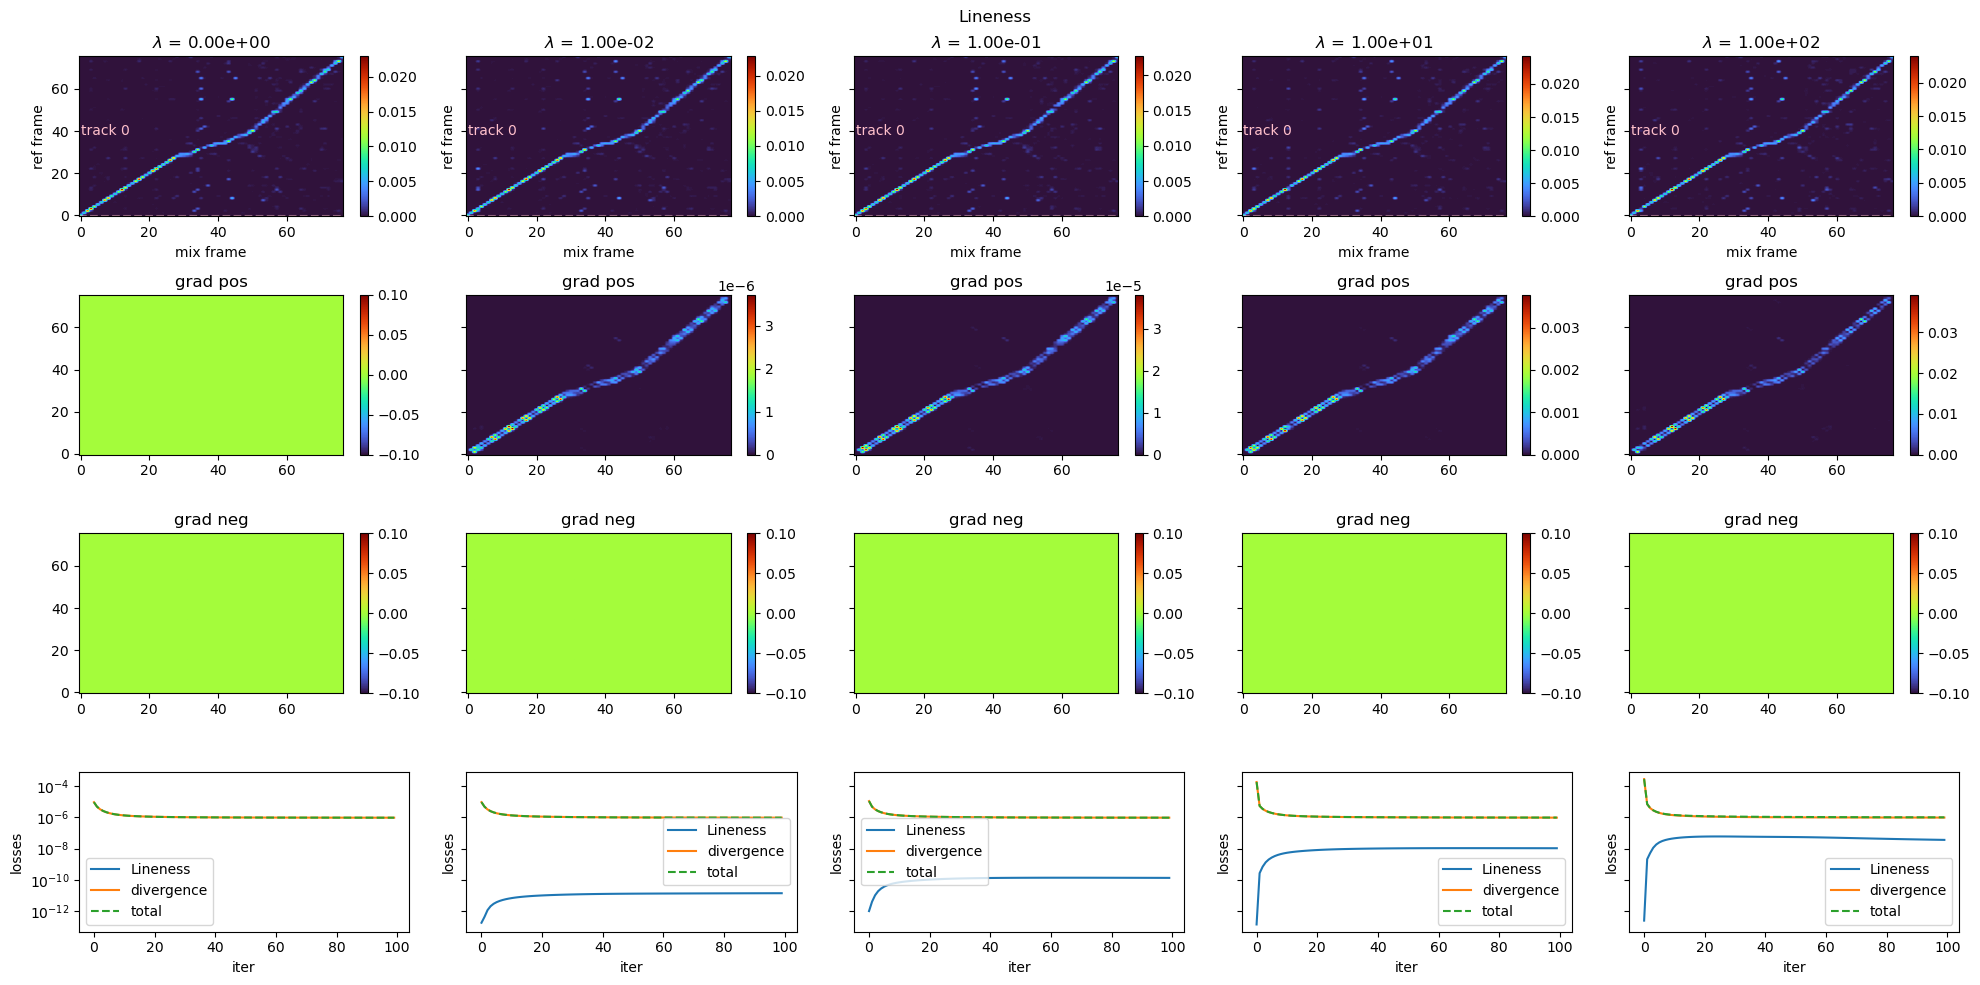

In [11]:
import activation_learner, plot
import librosa
import itertools

FS = 22050
# input_paths = ["linear-mix-1.wav", "linear-mix-2.wav", "linear-mix.wav"]
dataset = SyntheticDB()
mix = dataset.get_mix("stretch")
inputs = mix.as_activation_learner_input()
OVERLAP_FACTOR = 4
HOP_SIZE = 0.1
BETA = 0
NMELS = 128
# stop conditions
ITER_MAX = 1000
# logging
DIVERGENCE = pytorch_nmf.BetaDivergence(1)
PENALTIES = [
    pytorch_nmf.L1(),
    pytorch_nmf.L2(),
    pytorch_nmf.SmoothOverCol(),
    pytorch_nmf.SmoothOverRow(),
    pytorch_nmf.SmoothDiago(),
    pytorch_nmf.Lineness(),
]
LAMBDAS = [0, 1e-2, 1e-1, 1e1, 1e2]
for penalty in PENALTIES:
    fig, axs = plt.subplots(4, len(LAMBDAS), sharey="row")
    fig.set_size_inches(20, 10)
    fig.suptitle(f"{penalty.__class__.__name__}")

    for p, lambda_ in enumerate(LAMBDAS):
        learner = activation_learner.ActivationLearner(
            inputs,
            fs=FS,
            n_mels=NMELS,
            win_size=HOP_SIZE * OVERLAP_FACTOR,
            hop_size=HOP_SIZE,
            divergence=DIVERGENCE,
            penalties=[(penalty, lambda_)],
            spec_power=1
        )
        losses = learner.fit(ITER_MAX, loss_every=10)

        plot.plot_H(learner.nmf.H.detach().numpy(), learner.split_idx, ax=axs[0, p])
        fig.colorbar(axs[0, p].images[0], ax=axs[0, p])
        axs[0, p].set_title(f"$\\lambda$ = {lambda_:.2e}")
        axs[1, p].imshow(
            lambda_ * penalty.grad_pos(learner.nmf.H).detach().numpy(),
            origin="lower",
            cmap="turbo",
            aspect="auto",
        )
        fig.colorbar(axs[1, p].images[0], ax=axs[1, p])
        axs[1, p].set_title("grad pos")
        axs[2, p].imshow(
            lambda_ * penalty.grad_neg(learner.nmf.H).detach().numpy(),
            origin="lower",
            cmap="turbo",
            aspect="auto",
        )
        fig.colorbar(axs[2, p].images[0], ax=axs[2, p])
        axs[2, p].set_title("grad neg")
        plot.plot_loss_history(losses, ax=axs[3, p])
    plt.tight_layout()
    plt.show()